In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
project = 'herault_hematopoiesis'
model_dir = work_dir + 'models/' + project + '/'
output_dir = work_dir + 'simulation_files/'
traj_dir = work_dir + 'models/' 

In [2]:
traj_data = pd.read_csv(traj_dir + project+'_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['iHSC']
node_inactive = list(initial_state.index[initial_state==0])
node_active = list(initial_state.index[initial_state==1])

In [3]:
# Create blank file to get the results
ensemble_results = {}
 
model_list = os.listdir(model_dir)

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(model_dir + model)

    # Setup the model initial condition
    ## Put all inputs at 0
    for i in node_inactive:
        simulations.network.set_istate(i,[1,0])
    ## Put all miR at 1
    for i in node_active:
        simulations.network.set_istate(i,[0,1])

    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 40,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv(output_dir + project +'_simulation.csv')

100%|██████████| 617/617 [01:31<00:00,  6.71it/s]


In [4]:
cl_df = pd.read_csv(output_dir + project+'_simulation.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [12]:
# Initialize PCA (let's reduce to 2 principal components for this example)
pca = PCA(n_components=5)

# Fit and transform the data
df_pca = cl_df.drop(['model_id','timepoint'], axis = 1) 
pca_result = pca.fit_transform(df_pca)

# Convert the result back to a DataFrame for easier interpretation
pca_df = pd.DataFrame(data=pca_result, index=df_pca.index)

# number pca column
number_list = list(range(pca_result.shape[1]))
str_list = [str(i+1) for i in number_list]
pca_df.columns = ['pc' + s for s in str_list]

# Add model_id and timepoint backinto dataframe
pca_df['model_id'] = cl_df['model_id']
pca_df['timepoint'] = cl_df['timepoint'].astype('float')

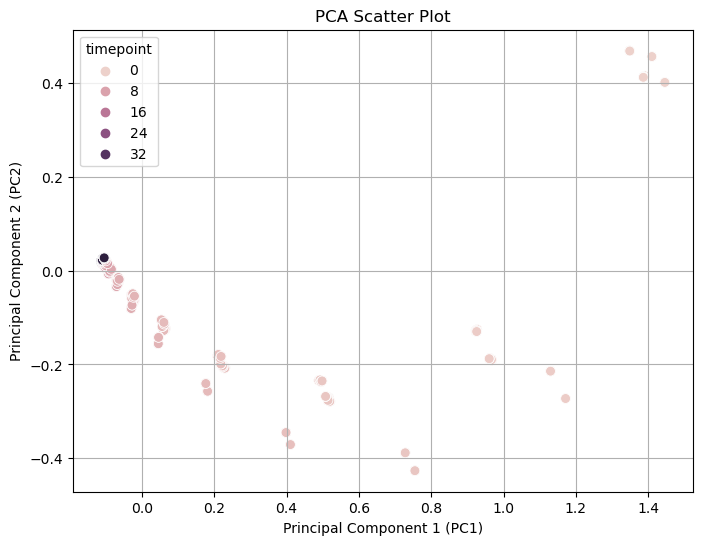

In [13]:
plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(data = pca_df, x='pc1', y='pc2', s=50, hue = pca_df['timepoint'])

# Add title and labels
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

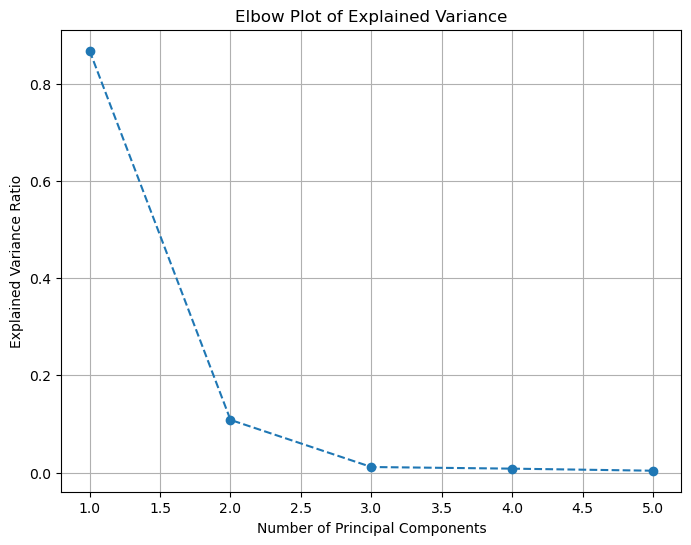

In [7]:
explained_variance_ratio = pca.explained_variance_ratio_

# Create an array with the number of components (1, 2, ..., n)
components = np.arange(1, len(explained_variance_ratio) + 1)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')

# Add titles and labels
plt.title('Elbow Plot of Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')

# Add a grid
plt.grid(True)

# Display the plot
plt.show()

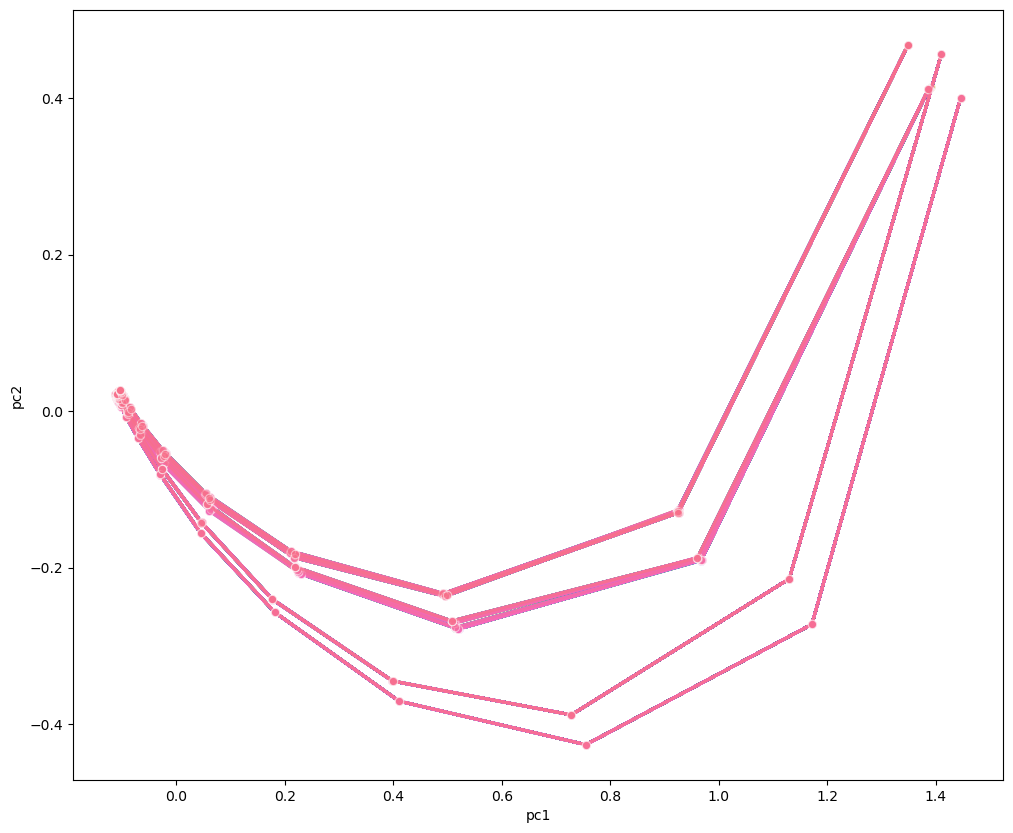

In [14]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_df,
                        x = 'pc1', y = 'pc2',
                        hue = pca_df['model_id'], sort = False,
                        marker = 'o', linewidth = 2,
                        alpha = .5 
                        #markersize = 10
                        )
    plot.get_legend().remove()

plt.show()

# Trajectory comparison using single variable from PCA

In [10]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.000 --> 0.000 --> 0.000 --> 


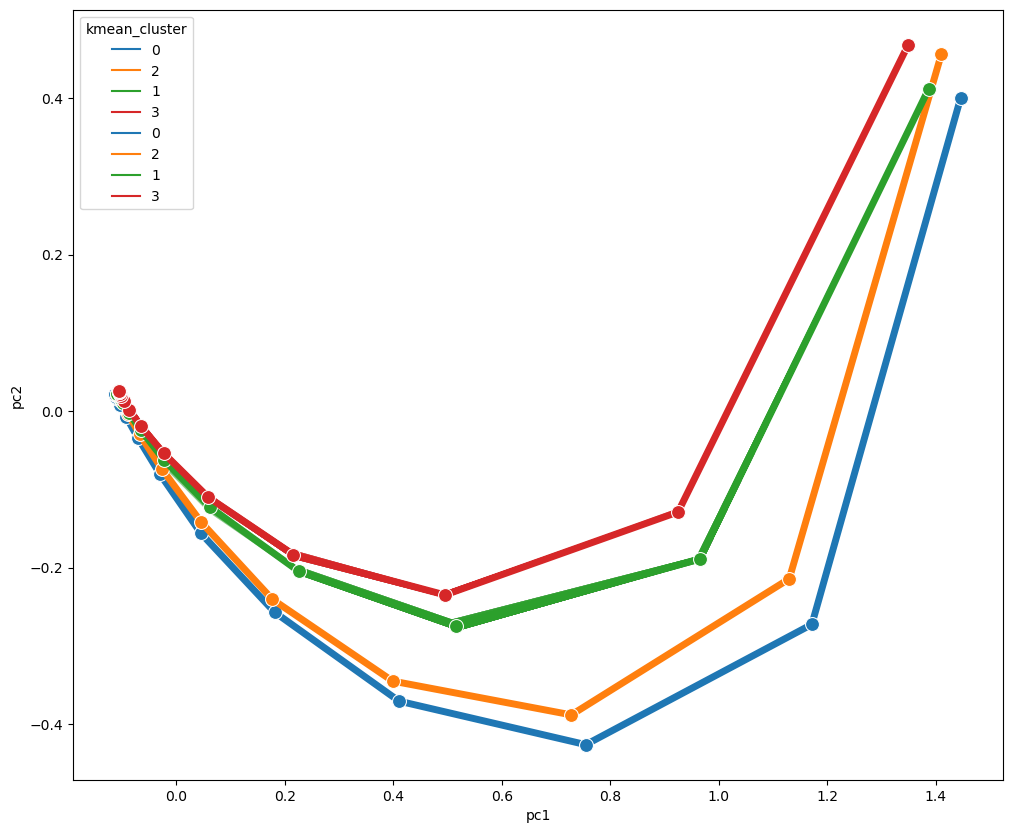

In [16]:
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_df.loc[pca_df.model_id == i,['pc1','pc2']].values
    model_pca_all[i] = np.array(model_pca)

pca_all_trajectory = np.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=4, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_df['kmean_cluster'] = pca_df['model_id']
pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_df.groupby(['timepoint','kmean_cluster'])[['pc1','pc2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_df, 
                        x = 'pc1',y='pc2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pc1',y='pc2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

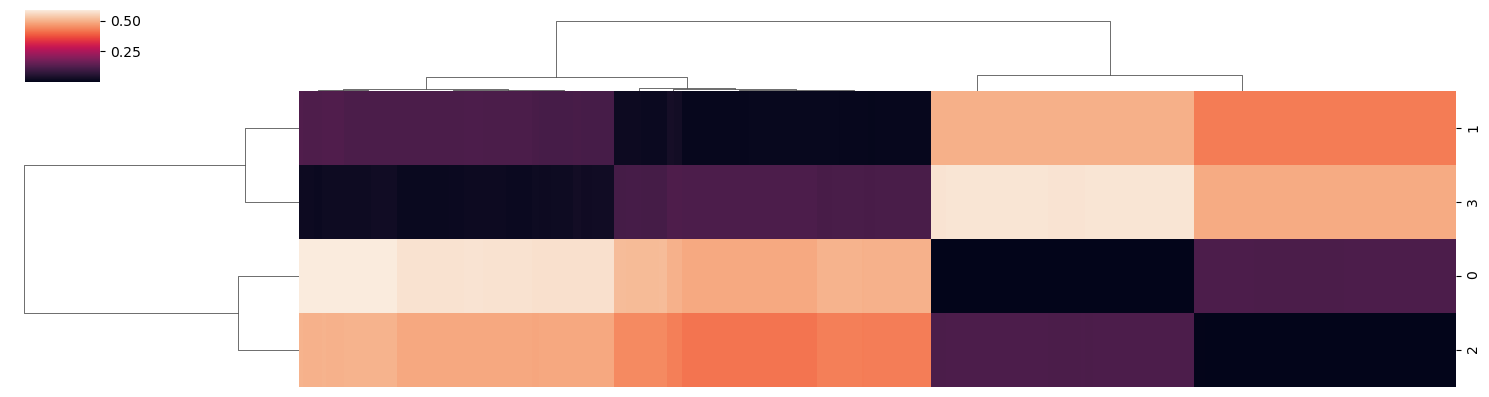

In [17]:
# Obtain the distance space from `tslearn`
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
distance_space.index = list(model_pca_all.keys())

# Plot the distance space to each cluster for each model
sns.clustermap(distance_space.transpose(), figsize = (15,4), xticklabels=False)
plt.show()

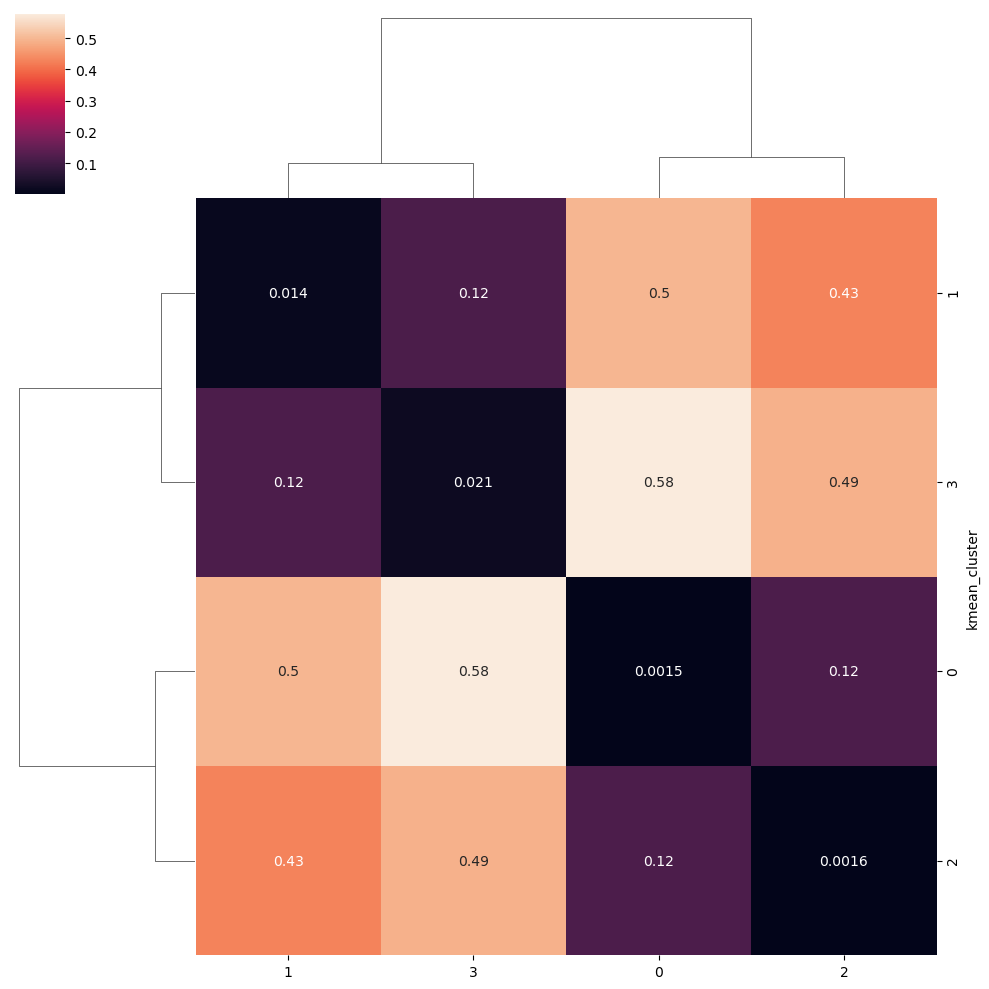

In [18]:
# Attach cluster information
distance_space['kmean_cluster'] = list(distance_space.index)
distance_space['kmean_cluster'] = distance_space['kmean_cluster'].replace(cluster_dict)
distance_space_group = distance_space.groupby(['kmean_cluster']).mean()

# Plot the distance space by group
sns.clustermap(distance_space_group, figsize = (10,10), annot = True)
plt.show()

In [19]:
pd.Series(cluster_dict).to_csv(output_dir + project + '_cluster.csv')

In [20]:
model_cluster = pd.DataFrame.from_dict(cluster_dict, orient = 'index', columns = ['cluster'])
model_cluster.to_csv(work_dir + '/model_cluster.csv')